<a href="https://colab.research.google.com/github/megsdata/sEMG_SupervisedLearning/blob/main/23Jul09_Deep_Learning_MMG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
import pathlib
import os
import datetime
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
import weightwatcher as ww
import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)
np.set_printoptions(precision=4)
print(tf.version.VERSION)

2.12.0


In [2]:
!pip install WeightWatcher
#!pip install pyyaml
#!pip install h5py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.8/69.8 kB 3.0 MB/s eta 0:00:00


In [4]:
import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(ww.__name__)
logger.setLevel(logging.INFO)
checkpoint_path = "logs/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [5]:
from google.colab import drive
drive.mount('/MSC_THESIS/')
%cd /MSC_THESIS/MyDrive/School - Ryerson Graduate/MSC_THESIS/23Jul09_Envelope_DL_Data
import pathlib
all_files =  sorted(str(p) for p in pathlib.Path('/MSC_THESIS/MyDrive/School - Ryerson Graduate/MSC_THESIS/23Jul09_Envelope_DL_Data/').glob("*.csv"))
#print(all_files)
df = pd.read_csv("/MSC_THESIS/MyDrive/School - Ryerson Graduate/MSC_THESIS/23Jul09_Envelope_DL_Data/_11_MATRIX.csv")
for i in range(len(all_files)-1):
  temp = pd.read_csv(all_files[i])
  df = pd.concat([df, temp], axis=0)
  #print(len(df.index))
df['ContractionDuration'] = df['Contraction End Time (s)'] - df['Contraction Start Time(s)']

Mounted at /MSC_THESIS/
/MSC_THESIS/MyDrive/School - Ryerson Graduate/MSC_THESIS/23Jul09_Envelope_DL_Data


In [6]:
df.head()

,Participant ID,Trial ID,Trial Type,Pulse Width,Contraction Start Time(s),Contraction End Time (s),ContractionNo,Pain Label,Sex,Age,...,Weight,Previous Injury,Fibula Length,Shank Girth,Time(s),EMG(mv),MMG_x,MMG_y,MMG_z,ContractionDuration
0,1,11,1,2.677351,6.506103,9.183454,1,1,1,23,...,50.0,0,35.0,35.0,6.5062,95.524229,1.591994,1.301494,1.546334,2.677351
1,1,11,1,2.677351,6.506103,9.183454,1,1,1,23,...,50.0,0,35.0,35.0,6.5064,95.876228,1.596378,1.301486,1.546180,2.677351
2,1,11,1,2.677351,6.506103,9.183454,1,1,1,23,...,50.0,0,35.0,35.0,6.5066,96.267965,1.600714,1.301478,1.546035,2.677351
3,1,11,1,2.677351,6.506103,9.183454,1,1,1,23,...,50.0,0,35.0,35.0,6.5068,96.670317,1.604998,1.301471,1.545901,2.677351
4,1,11,1,2.677351,6.506103,9.183454,1,1,1,23,...,50.0,0,35.0,35.0,6.5070,97.063615,1.609228,1.301467,1.545781,2.677351


Helper Functions

In [7]:
def data_prep(my_state):
  #select features
  X = df[['Trial Type', 'ContractionDuration', 'Pulse Width', \
          'Contraction Start Time(s)', 'Contraction End Time (s)', 'ContractionNo', \
          'Sex', 'Age', 'Height', 'Weight', 'Previous Injury', 'Fibula Length', 'Shank Girth', \
          'Time(s)', 'EMG(mv)', 'MMG_x', 'MMG_y', 'MMG_z', 'ContractionDuration'
          ]]
  y = df['Pain Label']
  #create data split
  from sklearn.model_selection import train_test_split
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=my_state)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=my_state)
  print("Number of samples in the training set: ", len(X_train))
  print("Number of samples in the test set: ", len(X_test))
  print("Number of samples in the validation set: ", len(X_val))
  #scale the data
  from sklearn.preprocessing import StandardScaler
  scaler = StandardScaler()
  X_train_scaled = scaler.fit_transform(X_train)
  X_test_scaled = scaler.transform(X_test)
  X_val_scaled = scaler.transform(X_val)
  return X_train_scaled, X_test_scaled, X_val_scaled, y_train, y_test, y_val

In [47]:
def create_CNN_model(my_state, num_feat):
  tf.random.set_seed(my_state)
  model = tf.keras.Sequential([
      tf.keras.layers.Conv1D(100, num_feat, activation='relu', name="convLayer", input_shape=(num_feat, 1)),
      tf.keras.layers.Dense(1024, activation='relu', name="relu1Layer"),
      #tf.keras.layers.Conv1D(100, num_feat, activation='relu', name="2ndconvLayer", input_shape=(None, 1, 100000)),
      tf.keras.layers.Dense(256, activation='relu', name="relu2Layer"),
      tf.keras.layers.Dense(256, activation='relu', name="relu3Layer"),
      tf.keras.layers.Dense(256, activation='relu', name="relu4Layer"),
      tf.keras.layers.Dense(256, activation='relu', name="relu5Layer"),
      tf.keras.layers.Dense(256, activation='relu', name="relu6Layer"),
      tf.keras.layers.Dense(256, activation='relu', name="relu7Layer"),
      tf.keras.layers.Dense(256, activation='relu', name="relu8Layer"),
      tf.keras.layers.Dense(256, activation='relu', name="relu9Layer"),
      tf.keras.layers.Dense(256, activation='relu', name="relu10Layer"),
      tf.keras.layers.Dense(1, activation='sigmoid', name="sigmoidLayer")
      #tf.keras.layers.Dense(1, activation='relu', name="sigmoidLayer")
  ])

  model.compile(
    loss=tf.keras.losses.binary_crossentropy,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.BinaryCrossentropy(name='binary cross entropy'),
        tf.keras.metrics.BinaryIoU(name='binary IoU'),
        tf.keras.metrics.F1Score(average=None, threshold=None, name='f1_score', dtype=None)
    ]
  )
  return model

def create_LSTM_model(my_state, num_feat):
  tf.random.set_seed(my_state)
  model = tf.keras.Sequential([
      #tf.keras.layers.LSTM(128, input_shape=(num_feat, 1)),
      tf.keras.layers.LSTM(256, input_shape=(num_feat, 1)),
      tf.keras.layers.Dense(128, activation='relu', name="relu1Layer"),
      tf.keras.layers.Dense(256, activation='relu', name="relu2Layer"),
      tf.keras.layers.Dense(256, activation='relu', name="relu3Layer"),
      tf.keras.layers.Dense(1, activation='sigmoid', name="sigmoidLayer")
  ])
  model.compile(
    loss=tf.keras.losses.binary_crossentropy,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.BinaryCrossentropy(name='binary cross entropy'),
        tf.keras.metrics.BinaryIoU(name='binary IoU'),
        tf.keras.metrics.F1Score(average=None, threshold=None, name='f1_score', dtype=None)
    ]
  )
  return model

def create_regularized_LSTM_model(my_state, factor, rate, num_feat):
  tf.random.set_seed(my_state)
  model = tf.keras.Sequential([
      #Dropout(rate),
      tf.keras.layers.LSTM(256, kernel_regularizer=l2(factor), input_shape=(num_feat, 1)),
      Dropout(rate),
      tf.keras.layers.LSTM(128, input_shape=(256, 1)),
      Dropout(rate),
      tf.keras.layers.Dense(128, kernel_regularizer=l2(factor), activation='relu', name="relu1Layer"),
      Dropout(rate),
      tf.keras.layers.Dense(256, kernel_regularizer=l2(factor), activation='relu', name="relu2Layer"),
      Dropout(rate),
      tf.keras.layers.Dense(256, kernel_regularizer=l2(factor), activation='relu', name="relu3Layer"),
      Dropout(rate),
      tf.keras.layers.Dense(1, activation='sigmoid', name="sigmoidLayer")
      #tf.keras.layers.Dense(1, activation='relu', name="reluLayer")
  ])

  model.compile(
      loss=tf.keras.losses.binary_crossentropy,
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
      metrics=[
          tf.keras.metrics.BinaryAccuracy(name='accuracy'),
          tf.keras.metrics.Precision(name='precision'),
          tf.keras.metrics.Recall(name='recall'),
          tf.keras.metrics.BinaryCrossentropy(name='binary cross entropy'),
          tf.keras.metrics.BinaryIoU(name='binary IoU'),
          tf.keras.metrics.F1Score(average=None, threshold=None, name='f1_score', dtype=None)
      ]
  )
  return model

def train_model(X_train_scaled, y_train, num_epochs):
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
  print("Training the neural network.. ")
  history = model.fit(X_train_scaled, y_train, batch_size=32, epochs=num_epochs, callbacks=[cp_callback])
  model.summary()
  return history

def visualize_performance(num_epochs, history):
  import matplotlib.pyplot as plt
  from matplotlib import rcParams
  rcParams['figure.figsize'] = (18, 8)
  rcParams['axes.spines.top'] = False
  rcParams['axes.spines.right'] = False
  plt.plot(
      np.arange(1, num_epochs+1),
      history.history['loss'], label='Loss'
  )
  plt.plot(
      np.arange(1, num_epochs+1),
      history.history['accuracy'], label='Accuracy'
  )
  plt.plot(
      np.arange(1, num_epochs+1),
      history.history['precision'], label='Precision'
  )
  plt.plot(
      np.arange(1, num_epochs+1),
      history.history['recall'], label='Recall'
  )
  plt.title('Evaluation metrics', size=20)
  plt.xlabel('Epoch', size=14)
  plt.legend();

def evaluate_performance(model, X_test_scaled, y_test):
  predictions = model.predict(X_test_scaled)
  prediction_classes = [
      1 if prob > 0.5 else 0 for prob in np.ravel(predictions)
  ]
  prediction_classes = [
      1 if prob > 0.5 else 0 for prob in np.ravel(predictions)
  ]
  from sklearn.metrics import accuracy_score, precision_score, recall_score

  print(f'Accuracy: {accuracy_score(y_test, prediction_classes):.4f}')
  print(f'Precision: {precision_score(y_test, prediction_classes):.4f}')
  print(f'Recall: {recall_score(y_test, prediction_classes):.4f}')

In [23]:
#choose a random state
%load_ext tensorboard
checkpoint_dir = "/MSC_THESIS/MyDrive/School - Ryerson Graduate/MSC_THESIS/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
my_state = 16
num_epochs = 1
X_train_scaled, X_test_scaled, X_val_scaled, y_train, y_test, y_val = data_prep(my_state)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Number of samples in the training set:  3240141
Number of samples in the test set:  1012545
Number of samples in the validation set:  810036


Training the neural network.. 
25307/25314 [============================>.] - ETA: 0s - loss: 4.5391 - accuracy: 0.7023 - precision: 0.7024 - recall: 1.0000 - binary cross entropy: 4.5391 - binary IoU: 0.3512
Epoch 1: saving model to logs/cp.ckpt
25314/25314 [==============================] - 183s 7ms/step - loss: 4.5390 - accuracy: 0.7024 - precision: 0.7024 - recall: 1.0000 - binary cross entropy: 4.5390 - binary IoU: 0.3512
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 relu1Layer (Dense)          (None, 1024)              20480     
                                                                 
 relu2Layer (Dense)          (None, 256)               262400    
                                                                 
 relu3Layer (Dense)          (None, 256)               65792     
                                                                 
 relu4Layer (Dense)

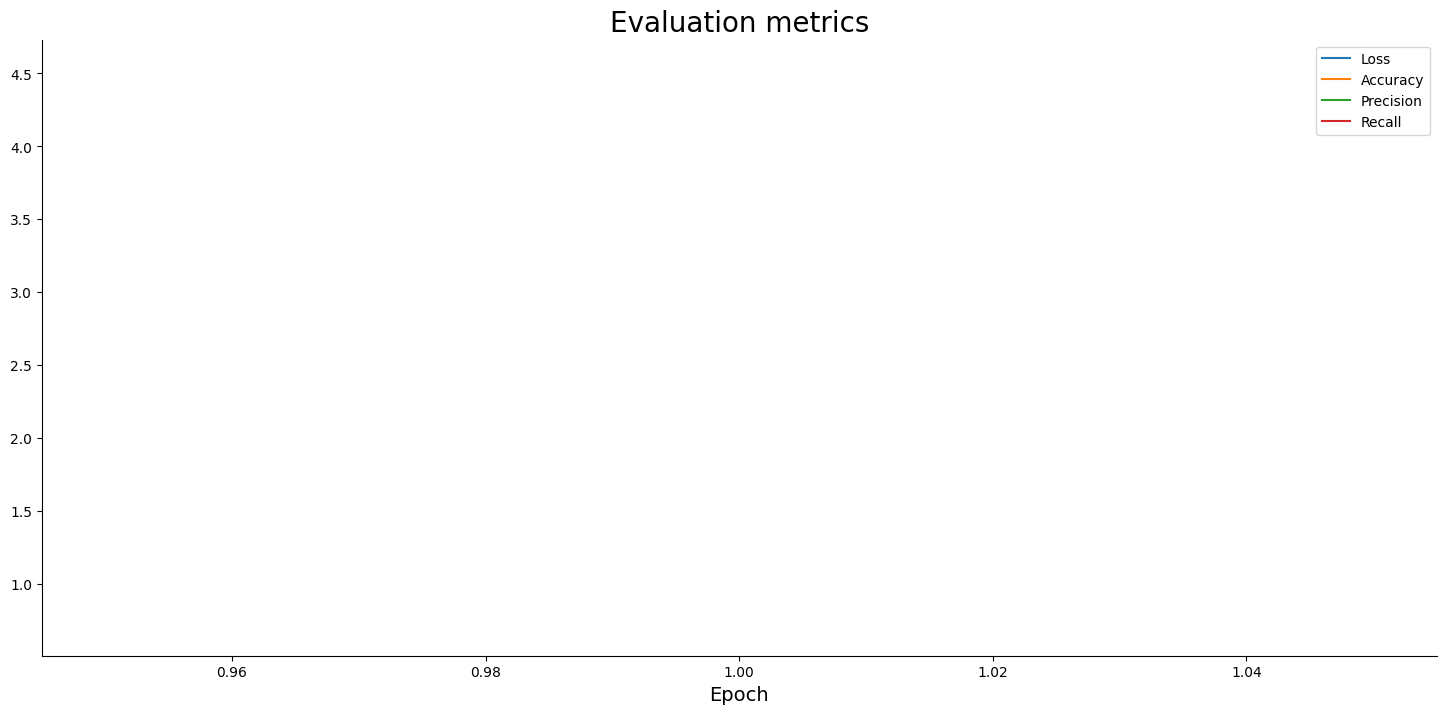

In [18]:
model = create_CNN_model(my_state, 19) #model creation and compilation
history = train_model(X_val_scaled, y_val, num_epochs) #validation
visualize_performance(num_epochs, history)
evaluate_performance(model, X_test_scaled, y_test)
model.summary()

In [42]:
my_state = 18
num_epochs = 10
# Create a callback that saves the model's weights
checkpoint_path = "/MSC_THESIS/MyDrive/School - Ryerson Graduate/MSC_THESIS/logs/23Jul09/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
model = create_LSTM_model(my_state, 19) #model creation and compilation
model.save_weights(checkpoint_path.format(epoch=0))
print(model)

Training the neural network.. 
Epoch 1/10
101253/101255 [============================>.] - ETA: 0s - loss: 0.0578 - accuracy: 0.9791 - precision: 0.9859 - recall: 0.9844 - binary cross entropy: 0.0578 - binary IoU: 0.9515
Epoch 1: saving model to /MSC_THESIS/MyDrive/School - Ryerson Graduate/MSC_THESIS/logs/23Jul09/cp-0001.ckpt
101255/101255 [==============================] - 652s 6ms/step - loss: 0.0578 - accuracy: 0.9791 - precision: 0.9859 - recall: 0.9844 - binary cross entropy: 0.0578 - binary IoU: 0.9515
Epoch 2/10
101252/101255 [============================>.] - ETA: 0s - loss: 0.1212 - accuracy: 0.9519 - precision: 0.9683 - recall: 0.9630 - binary cross entropy: 0.1212 - binary IoU: 0.8924
Epoch 2: saving model to /MSC_THESIS/MyDrive/School - Ryerson Graduate/MSC_THESIS/logs/23Jul09/cp-0002.ckpt
101255/101255 [==============================] - 635s 6ms/step - loss: 0.1213 - accuracy: 0.9519 - precision: 0.9683 - recall: 0.9630 - binary cross entropy: 0.1213 - binary IoU: 0.8924

['cp-0000.ckpt.data-00000-of-00001',
 'cp-0000.ckpt.index',
 'checkpoint',
 'cp-0001.ckpt.data-00000-of-00001',
 'cp-0001.ckpt.index',
 'cp-0002.ckpt.data-00000-of-00001',
 'cp-0002.ckpt.index',
 'cp-0003.ckpt.data-00000-of-00001',
 'cp-0003.ckpt.index',
 'cp-0004.ckpt.data-00000-of-00001',
 'cp-0004.ckpt.index',
 'cp-0005.ckpt.data-00000-of-00001',
 'cp-0005.ckpt.index',
 'cp-0006.ckpt.data-00000-of-00001',
 'cp-0006.ckpt.index',
 'cp-0007.ckpt.data-00000-of-00001',
 'cp-0007.ckpt.index',
 'cp-0008.ckpt.data-00000-of-00001',
 'cp-0008.ckpt.index',
 'cp-0009.ckpt.data-00000-of-00001',
 'cp-0009.ckpt.index',
 'cp-0010.ckpt.data-00000-of-00001',
 'cp-0010.ckpt.index']

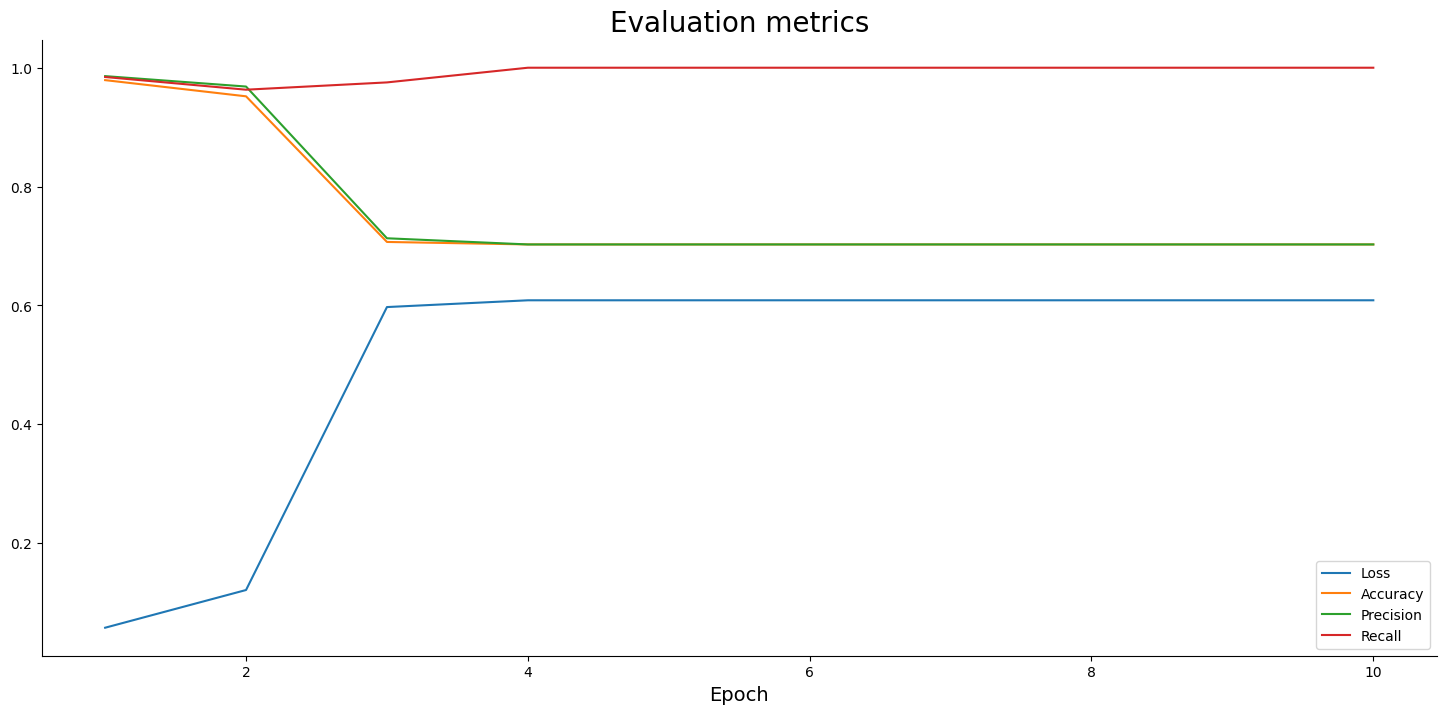

In [43]:
history = train_model(X_train_scaled, y_train, num_epochs)
visualize_performance(num_epochs, history)
evaluate_performance(model, X_test_scaled, y_test)
os.listdir(checkpoint_dir)


In [44]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

'/MSC_THESIS/MyDrive/School - Ryerson Graduate/MSC_THESIS/logs/23Jul09/cp-0010.ckpt'

In [45]:
y_pred= model.predict(X_test_scaled)


31643/31643 [==============================] - 63s 2ms/step


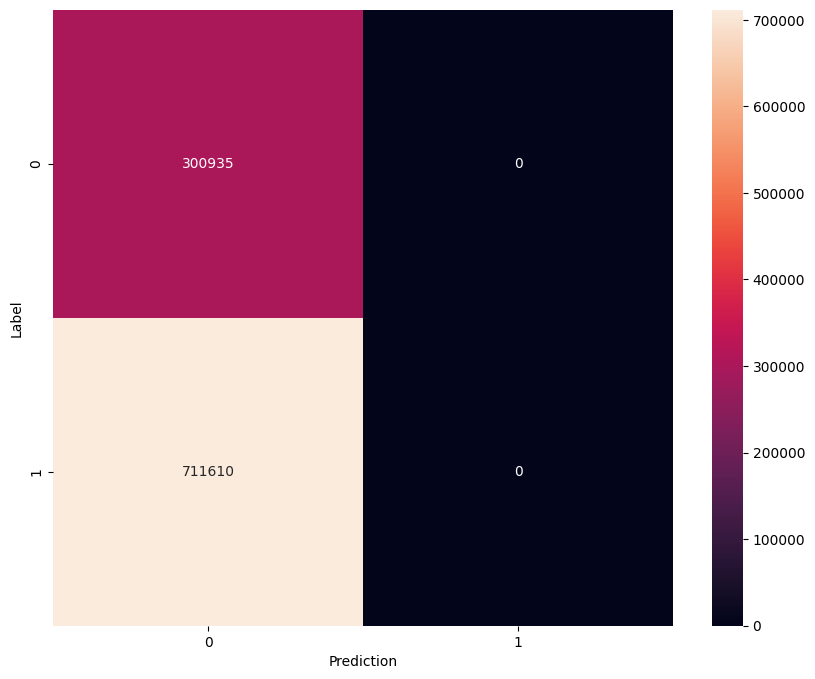

In [46]:
import seaborn as sns
confusion_mtx = tf.math.confusion_matrix(
    y_test,
    y_pred,
    num_classes=2,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None
)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, \
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [ ]:
my_state = 19
num_epochs = 10
# Create a callback that saves the model's weights
checkpoint_path = "/MSC_THESIS/MyDrive/School - Ryerson Graduate/MSC_THESIS/logs/23Jul09_Regularized_LSTM/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
model = create_LSTM_model(my_state, 19) #model creation and compilation
model.save_weights(checkpoint_path.format(epoch=0))
print(model)

In [11]:
model = create_regularized_LSTM_model(my_state, 1e-5, 0.3, 19) #model creation and compilation
#model = create_CNN_model(my_state, 4) #model creation and compilation
#history = train_model(X_train_scaled, y_train, num_epochs) #training
history = train_model(X_val_scaled, y_val, num_epochs) #regularize on validation set
visualize_performance(num_epochs, history)
evaluate_performance(model, X_test_scaled, y_test)

ValueError: ignored